# Financial data vizualisation and portfolio optimization

This notebook provide the portfolio optimization of 3 assets :

    - Apple stock
    - 10 years US treasury bond
    - Gold
    
The first part is here to visualize the data, then the portfolio is optimized with data from July to December 2023.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
tickers = ['AAPL', 'GC=F', '^TNX'] # We create the vector with the symbols for the desired assets

In [3]:
data = yf.download(tickers, start='2020-01-01', end='2023-04-01')['Adj Close'] # We download the data

[*********************100%%**********************]  3 of 3 completed


In [4]:
data.head()  

Ticker,AAPL,GC=F,^TNX
Date,,,
2020-01-02,73.059425,1524.500000,1.882
2020-01-03,72.349136,1549.199951,1.788
2020-01-06,72.925644,1566.199951,1.811
2020-01-07,72.582657,1571.800049,1.827
2020-01-08,73.750244,1557.400024,1.874


**We can clearly notice that the 3 assets have very differents rough size so we can't plot them together like this 
if we wante to see their evolution. I decided to to scale up the value of the US Treasury Bond so it get close to 
Apple values.**

In [5]:
data.insert(3,'10y_us_t_bond_x100',data['^TNX'] * 100)

In [6]:
data.head() # A new column is added so the real value remain in the dataframe

Ticker,AAPL,GC=F,^TNX,10y_us_t_bond_x100
Date,,,,
2020-01-02,73.059425,1524.500000,1.882,188.199997
2020-01-03,72.349136,1549.199951,1.788,178.799999
2020-01-06,72.925644,1566.199951,1.811,181.099999
2020-01-07,72.582657,1571.800049,1.827,182.700002
2020-01-08,73.750244,1557.400024,1.874,187.399995


In [7]:
data.rename(columns={'AAPL' : 'apple', '^TNX' : '10y_us_t_bond', 'GC=F' : 'gold'}, inplace = True) # To have clear column names

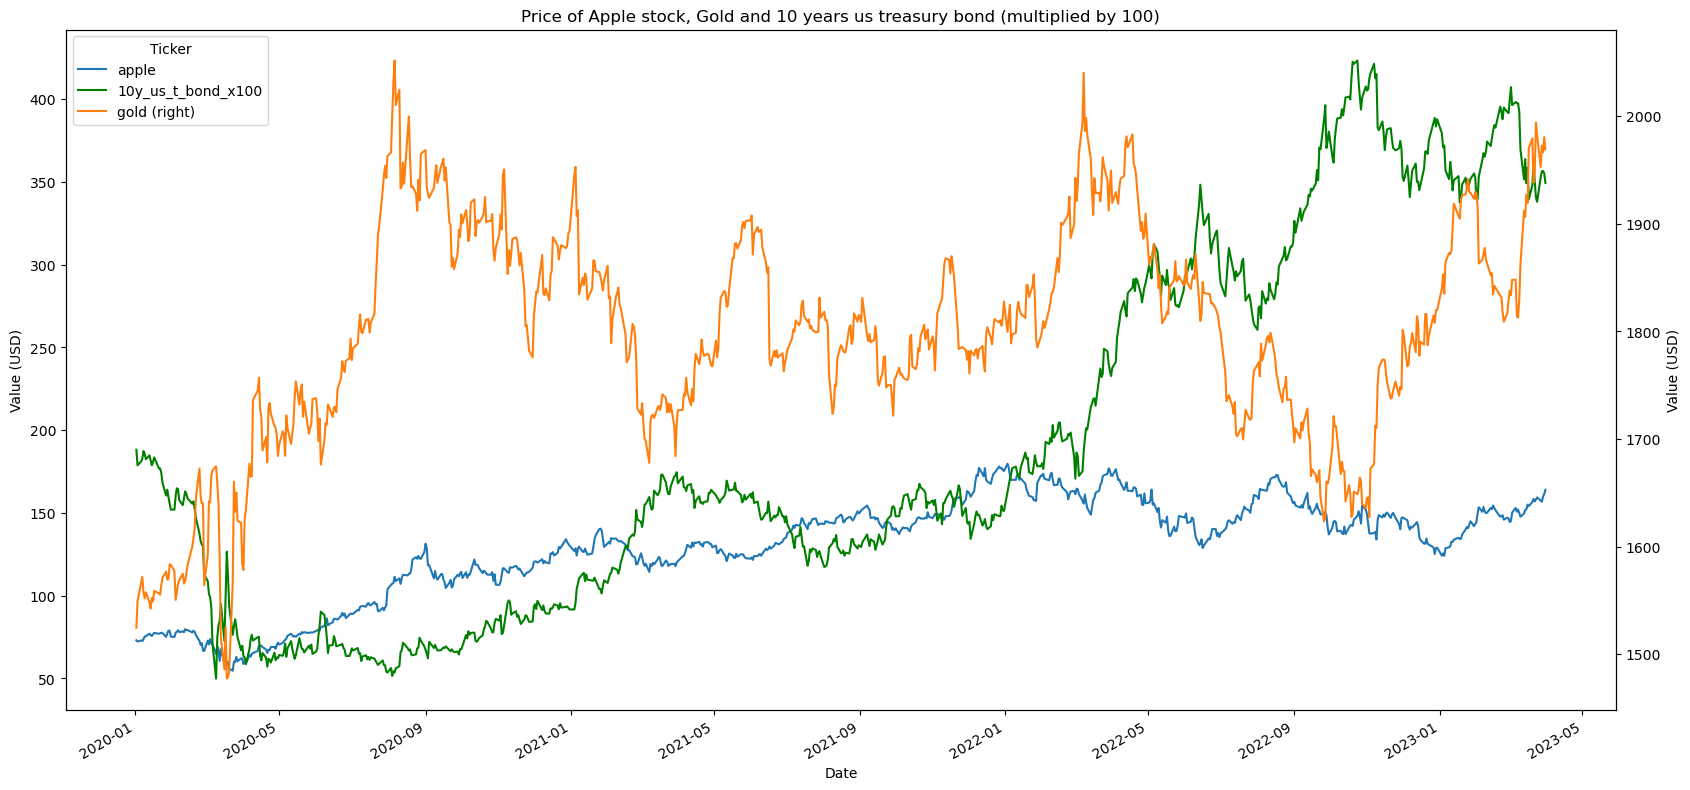

In [8]:
# Here is the plotting of the value of the 3 assets, Gold is plotted on the right vertical axis as its values are higher
fig, ax = plt.subplots(figsize=(20,10))
data.plot( y = ['apple', '10y_us_t_bond_x100'], ax=ax,color = ['tab:blue', 'green'],title = 'Price of Apple stock, Gold and 10 years us treasury bond (multiplied by 100)')
plt.ylabel('Value (USD)')
data.plot( y = 'gold', secondary_y = True, ax=ax, color='tab:orange')
plt.ylabel('Value (USD)')
data.drop(columns=['10y_us_t_bond_x100'], inplace=True) # The previously added column is deleted, as usefull only 
# for the plotting

In [9]:
data.head() # We get the initial dataframe with better names

Ticker,apple,gold,10y_us_t_bond
Date,,,
2020-01-02,73.059425,1524.500000,1.882
2020-01-03,72.349136,1549.199951,1.788
2020-01-06,72.925644,1566.199951,1.811
2020-01-07,72.582657,1571.800049,1.827
2020-01-08,73.750244,1557.400024,1.874


<Axes: title={'center': 'return of the 3 assets'}, xlabel='Date'>

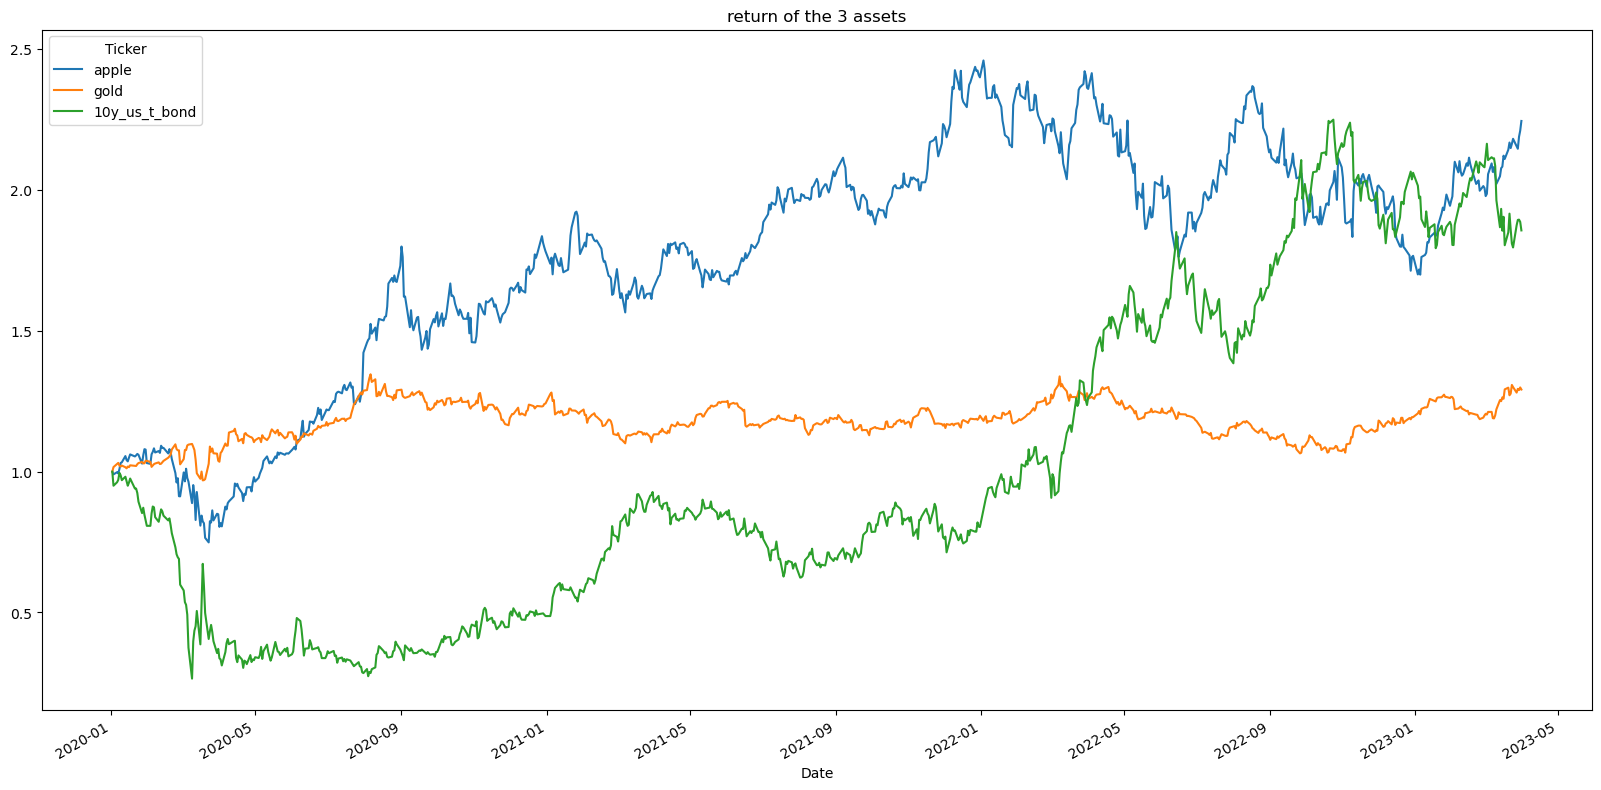

In [10]:
# Now we compute the return of the 3 assets, divide every value by the first one

ret = data.copy()
ret['apple'] = data['apple']/ data.iloc[0,0]
ret['10y_us_t_bond'] = data['10y_us_t_bond']/data.iloc[0,2]
ret['gold'] = data['gold']/data.iloc[0,1]

fig, ax = plt.subplots(figsize=(20,10))
ret.plot(ax=ax, title = 'return of the 3 assets')

Ticker,apple,gold,10y_us_t_bond
Date,,,
2020-01-03,-0.009770,0.016072,-0.051237
2020-01-06,0.007937,0.010914,0.012782
2020-01-07,-0.004714,0.003569,0.008796
2020-01-08,0.015958,-0.009204,0.025400
2020-01-09,0.021018,-0.003667,-0.008574


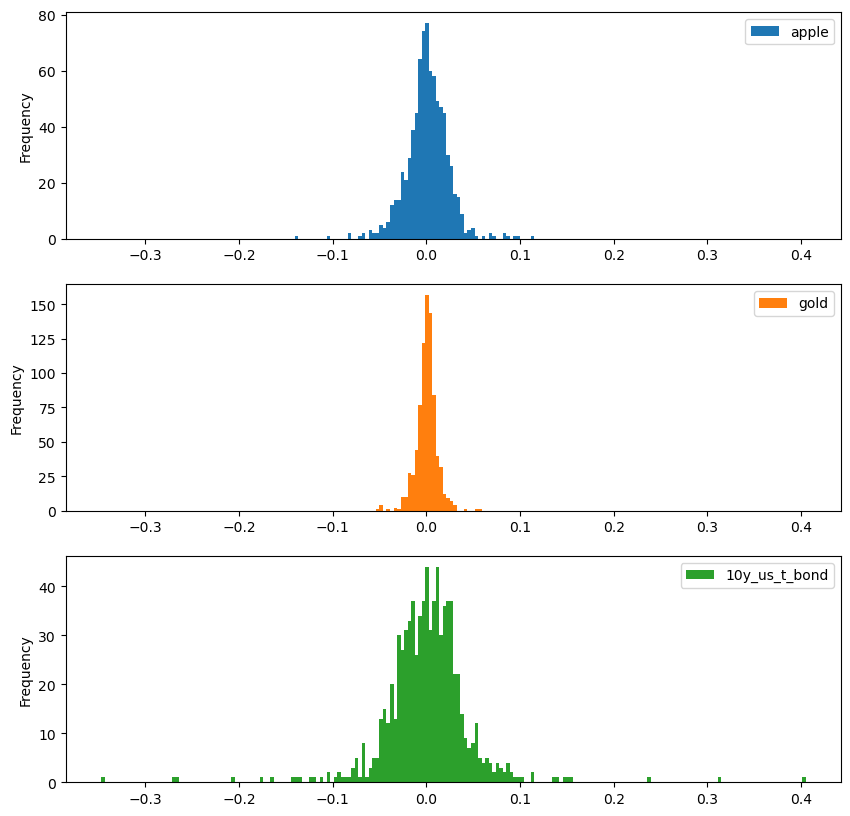

In [11]:
# We can also compute the logarithmic return, the distribution of the return should be a gaussian distribution

log_ret_1 = np.log(data/data.shift(1))
log_ret_1 = log_ret_1.dropna()
log_ret_1.plot(kind = 'hist', bins = 200, subplots=True, figsize=(10,10), sharex = False)
log_ret_1.head()

**Here starts the portfolio optimization using Monte-Carlo method**

In [12]:
# We first download the data :
data = yf.download(tickers, start='2023-07-01', end='2023-12-01')['Adj Close']

# Then the log return is computed 
log_ret_1 = np.log(data/data.shift(1))
log_ret = log_ret_1.copy()

# Definition of variables 

n = len(log_ret.columns)

n_iter = 5000
weights_vect = np.zeros((n_iter,n))
ret_vect = np.zeros(n_iter)
vol_vect = np.zeros(n_iter)
sharpe_r_vect = np.zeros(n_iter)

# Simulation

for i in range(n_iter):
    
    weights = np.array(np.random.random(n))
    weights = weights/np.sum(weights)
    weights_vect[i,:] = weights
    

    ret_vect[i] = np.sum((log_ret.mean()*weights)*252)

    vol_vect[i] = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))
        
    sharpe_r = ret_vect[i]/vol_vect[i]
    sharpe_r_vect[i] = sharpe_r

[*********************100%%**********************]  3 of 3 completed


Text(0, 0.5, 'Return')

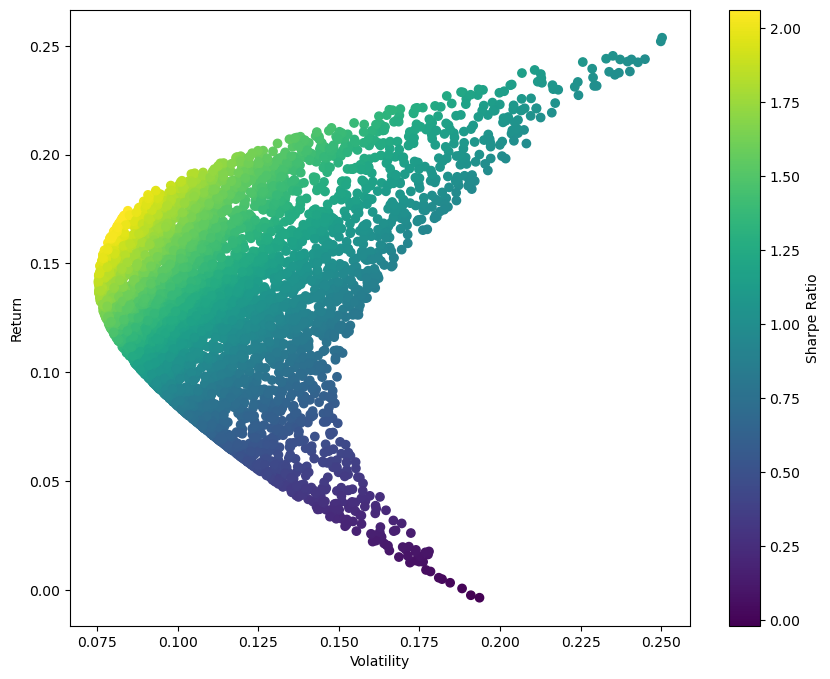

In [13]:
# To see the result we plot return as a function of volatility
plt.figure(figsize=(10,8))
plt.scatter(vol_vect, ret_vect, c=sharpe_r_vect)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

In [14]:
# Finally, we can display some weights distribution
w = weights_vect[vol_vect.argmin()]*100
print('The distribution with the min volatility of the 3 asset is : \nApple : %.0f \nGold : %.0f \nUS treasury bond : %.0f\n'%(w[0],w[1],w[2]))

s = weights_vect[sharpe_r_vect.argmax()]*100
print('The distribution with the max sharpe ratio of the 3 asset is : \nApple : %.0f \nGold : %.0f \nUS treasury bond : %.0f'%(s[0],s[1],s[2]))


The distribution with the min volatility of the 3 asset is : 
Apple : 16 
Gold : 64 
US treasury bond : 21

The distribution with the max sharpe ratio of the 3 asset is : 
Apple : 1 
Gold : 71 
US treasury bond : 27
